## Convolution Neural Network (CNN)
A CNN implemented in Keras trained with the MNIST dataset considting of images hand drawn numbers (0-9). The trained network is easily capable of classifying novel had drawn numbers with over 95% accuracy.<br>

<strong>UPDATES: 01/13/2020 Updated for TensorFlow 2.0, modified visualization of activations</strong><br>

<strong>Network Stucture:</strong><br>
Inputs - 28x28x1 grayscale images with each pixel represented by a byte from 0 (black) to 255 (white)<br>
Convolution Layer (2D) - 16 filters (feature/activation maps), 5x5 kernel, stride of one, rectified linear activation<br>
Max Pooling Layer (2D) - 2x2 pool size, stride of 2<br>
Covolution Layer (2D) - 32 filters, 5x5 kernel, stride of 2, rectified linear activation<br>
Max Pooling Layer (2D) - 2x2 pool size, stride of 1<br>
Fully Connected (Dense) - 128 nodes, rectified linear activation<br>
Fully Connected (Dense) - 10 nodes (one for each class/digit), softmax activation<br>

In [1]:
# import libraries and modules
import tensorflow as tf
from tensorflow.keras import models
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pylab as plt
import numpy as np

In [2]:
# check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Training the neural network will be slower.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [3]:
# load the MNIST data set, which is already splits into train and test data sets
(x_train, y_train), (x_test_validate, y_test_validate) = mnist.load_data()
# split the test data into a valiation and a test sample
x_test, x_validate = x_test_validate[:5000,:,:], x_test_validate[5000:,:,:]
y_test, y_validate = y_test_validate[:5000], y_test_validate[5000:]

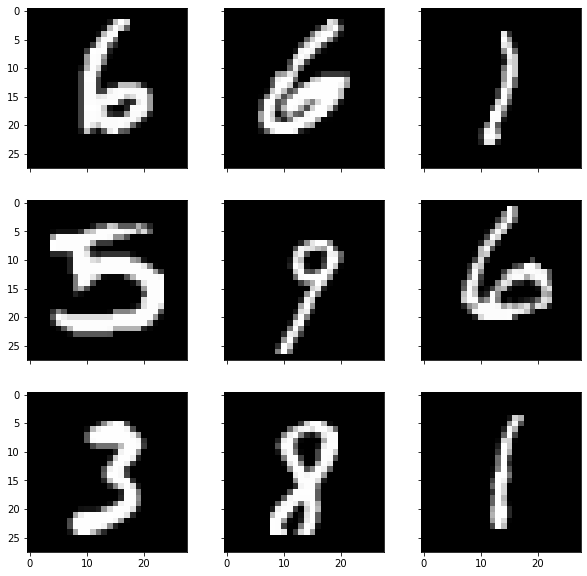

In [4]:
# show some examples from the MNIST training data set
fig = plt.figure(0, [10,10])
axes = fig.subplots(3, 3, sharex='col', sharey='row')
examples = np.random.choice(np.arange(x_train.shape[0]),size=9,replace=False) 
ii = 0
for row in axes:
    for col in row:
        col.imshow(x_train[examples[ii],:,:],cmap='gray')
        ii+=1
plt.show()

In [5]:
# do some preprocessing of the data

# some parameters
num_classes = 10 # number of distinct digits
img_x, img_y = 28, 28 # input image dimensions
input_shape = (img_x, img_y, 1) # shape of each image in collection

# some hyperparameters
batch_size = 128
epochs = 8

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel (last dimension) - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_validate = x_validate.reshape(x_validate.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)

# convert the data to the right type
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # normalize pixel values to between zero and one
x_validate /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validate = keras.utils.to_categorical(y_validate, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
60000 train samples
5000 validation samples
5000 test samples


In [6]:
# another hyperparameter
learning_rate = 0.001

# define the model
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

history = AccuracyHistory()

In [7]:
# train the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validate, y_validate),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)

Train on 60000 samples, validate on 5000 samples
Epoch 1/8
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2350 - accuracy: 0.9314 - val_loss: 0.0430 - val_accuracy: 0.9872
Epoch 2/8
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0602 - accuracy: 0.9816 - val_loss: 0.0207 - val_accuracy: 0.9940
Epoch 3/8
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0411 - accuracy: 0.9877 - val_loss: 0.0196 - val_accuracy: 0.9942
Epoch 4/8
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0149 - val_accuracy: 0.9946
Epoch 5/8
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0169 - val_accuracy: 0.9946
Epoch 6/8
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0169 - val_accuracy: 0.9936
Epoch 7/8
60000/60000 [==============================] - 2s 33u

Test loss: 0.04758430962874554
Test accuracy: 0.9862


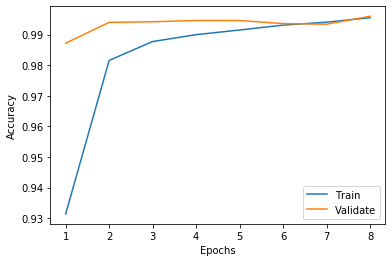

In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1,epochs+1), history.acc, range(1,epochs+1), history.val_acc)
plt.legend(['Train','Validate'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [9]:
# use the trained model to predict classes of x_test
y_test_prime = model.predict(x_test)
print(y_test_prime)
y_test_prime_class = np.argmax(y_test_prime,axis=1)
print(y_test_prime_class)

[[1.07375941e-10 4.44475745e-09 1.10345525e-07 ... 9.99998331e-01
  1.14689658e-09 2.01637064e-07]
 [2.32147030e-07 4.48261034e-07 9.99999285e-01 ... 9.06734201e-14
  1.18711156e-08 3.92217821e-11]
 [1.75900521e-08 9.99997973e-01 3.99149144e-07 ... 1.41308635e-06
  1.27585151e-08 1.68626144e-08]
 ...
 [2.04927957e-07 5.24149509e-05 9.91871476e-01 ... 5.70368925e-08
  3.14230681e-03 7.09256028e-07]
 [5.63039615e-10 1.92251459e-08 8.02816646e-10 ... 3.44405498e-06
  1.42963259e-07 9.65786171e-07]
 [1.00000000e+00 1.17204510e-12 1.77458326e-09 ... 1.25837639e-11
  5.76153326e-11 7.85005325e-11]]
[7 2 1 ... 2 4 0]


[4 5 2 9]


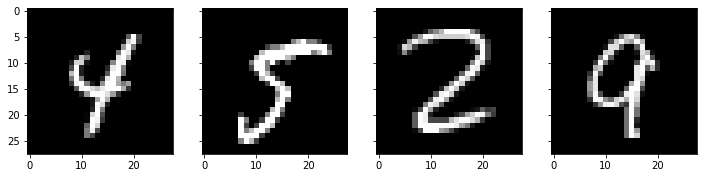

In [10]:
# show some specific predictions 
fig = plt.figure(0, [12, 3])
axes = fig.subplots(1, 4, sharex='col', sharey='row')
examples = np.random.choice(np.arange(x_test.shape[0]),size=4,replace=False)
print(y_test_prime_class[examples])
ii = 0
for col in axes:
    col.imshow(x_test[examples[ii],:,:].reshape(img_x,img_y),cmap='gray')
    ii+=1
plt.show()

### Look at some of the activations for the first prediction above

In [11]:
layer_outputs = [layer.output for layer in model.layers] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [12]:
one_test = x_test[examples[0]].reshape(1,28,28,1)
activations = activation_model.predict(one_test) # Returns a list of five Numpy arrays: one array per layer activation

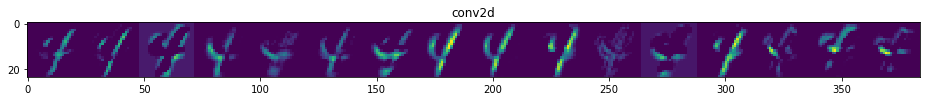

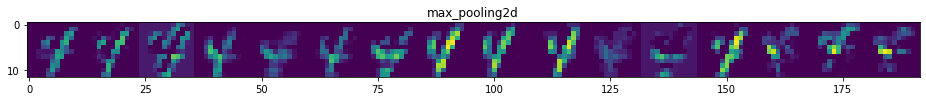

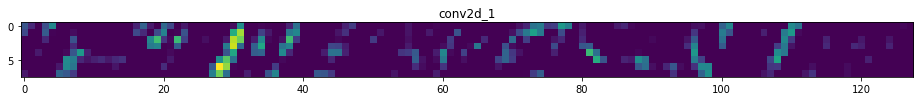

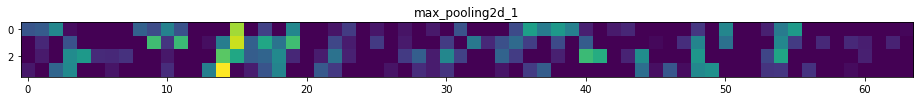

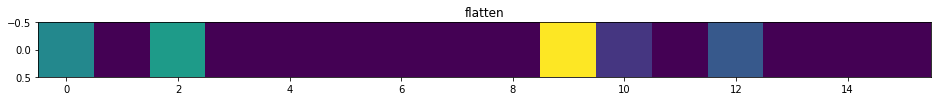

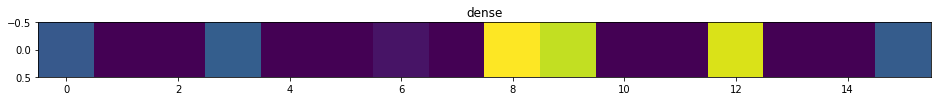

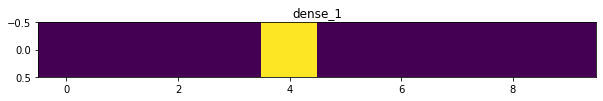

In [13]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
max_filters = 16 # maximum number of filters to print per layer

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    # print('layer activation shape:', layer_activation.shape)
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    
    if n_features < max_filters:
        filters_to_plot = n_features
    else:
        filters_to_plot = max_filters
        
    # filters are different shapes
    try: 
        channel_image = layer_activation[0, :, :, 0]
        size = layer_activation.shape[1]
    except:
        channel_image = layer_activation[0, 0] # some layers are flat
        size = 1
        
    display_grid = np.zeros((size, size*filters_to_plot))
    
    for col in range(filters_to_plot):
        try: 
            channel_image = layer_activation[0, :, :, col]
            size = layer_activation.shape[1]
        except:
            channel_image = layer_activation[0, col] # some layers are flat
            size = 1
        
        # print('image shape', channel_image.shape)
        # print('grid shape', display_grid.shape)
        
        display_grid[0: size, col * size : (col + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
